In [1]:
import skeleton as s
import numpy as np
import matplotlib.pyplot as plt

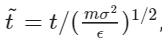

v^~ ->
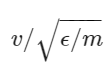

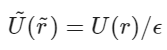

Kinetic energy in natural units:
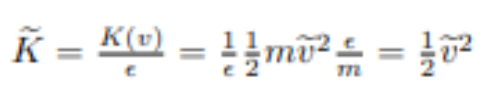

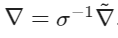

In [2]:
n = 2   #number of particles
L = 10   #System is of size LxL with the origin at the center. The units of L are of 1/s
init_pos = np.array([[1, 2, 3],[3, 5, 8]])
#init_vel = np.random.uniform(low=-1, high=1, size=(n, 3))
init_vel = np.zeros((n, 3))
e =  1.65 * pow(10,-21)
s =  3.405 * pow(10,-10)
time_step = 1e-2
m =  6.6335 * pow(10, -26) #mass of argon atom in kg

number_of_steps = 10
dimensions = 3

In [3]:
#print("initial pos\n", init_pos,"\n initial vel\n" ,init_vel)
times = np.arange(0,(number_of_steps + 1) * time_step, time_step)

In [4]:
W = L   #Width 
K = L   #Depth
def atomic_distances(pos, output, L=1, W=1): # output = 0 gives the relative distances, output = 1 gives the relative positions
    rel_pos = pos[:, None, :] - pos[None, :, :]                 # returns one matrix for each particle. Relative distances within the box
    rel_dist = np.zeros((n, n, 1))
    for i in range(n):
        for k in range(n):
            for l in range(dimensions):
                if l == 0: # x-values i.e. change by L
                    rel_pos[i,k,l] = min(rel_pos[i,k,l], (rel_pos[i,k,l]+L)%L, (rel_pos[i,k,l]-L)%L, rel_pos[i,k,l]+L, rel_pos[i,k,l]-L, key=abs) # takes the smallest distance comparing all images
                if l == 1:
                    rel_pos[i,k,l] = min(rel_pos[i,k,l], (rel_pos[i,k,l]+W)%W, (rel_pos[i,k,l]-W)%W, rel_pos[i,k,l]+W, rel_pos[i,k,l]-W, key=abs)
                if l == 2:
                    rel_pos[i,k,l] = min(rel_pos[i,k,l], (rel_pos[i,k,l]+K)%K, (rel_pos[i,k,l]-K)%K, rel_pos[i,k,l]+K, rel_pos[i,k,l]-K, key=abs)
    for i in range(n):    
        for k in range(n):
            rel_dist[i,k] = np.sqrt(np.dot(rel_pos[i,k,:],rel_pos[i,k,:]))
    
    if output == 0:
        return rel_dist
    elif output == 1:
        return rel_pos
    else:
        print("The second parameter in the lj_forces must be either 0(for distances) or 1(for positions)")

In [5]:
#compute the forces on the particles at each timestep, pos = [m]/[s] = 
def lj_force(position, n):
    
    rel_pos = atomic_distances(position[:,-3:], 1) # with pos = np.array(N_particels, 3)
    r = np.sqrt(np.sum((rel_pos)**2, axis=2)) #n x n simmetric matrix, r[i,j] is the distance between the i-th and the j-th particles
    r = r[0,1]
    F = np.zeros((n,3))
    F = -24*rel_pos*(((1/r)**12)-((1/r)**6))
    F_matrix=np.sum(F,axis=0)    
    
    return F_matrix

In [6]:
final_matrix_pos = np.copy(init_pos)
final_matrix_vel = np.copy(init_vel)

def euler(final_matrix_pos, final_matrix_vel):
    
    latest_pos = np.copy(final_matrix_pos[:,-3:])         # -3 is for the dimensions
    latest_vel = np.copy(final_matrix_vel[:,-3:])
    
    new_latest_pos = latest_pos + latest_vel * time_step
    new_latest_vel = latest_vel + lj_force(latest_pos, n)
    return new_latest_pos, new_latest_vel


In [7]:
#function to compute the kinetic energy
def kin_en(v): #v is the last step velocity
    K = 0.5*np.sum(v**2)
    return K

In [8]:
#function to compute the potential energy
def pot_en(position, n): #position is the matrix with all the positions stored in it, n is the number of particles
    current_pos = np.copy(position[:,-3:])
    rel_pos = atomic_distances(current_pos, 1) # with pos = np.array(N_particels, 3)
    r = np.sqrt(np.sum((rel_pos)**2, axis=2)) #n x n simmetric matrix, r[i,j] is the distance between the i-th and the j-th particles
    r = r[0,1]
    U = 4*(1/r**12 - 1/r**6)
    
    return U

Velocities:
 [[ 0.          0.          0.          0.          0.          0.00767951
   0.          0.          0.01535902  0.          0.          0.0230397
   0.          0.          0.03072275  0.          0.          0.03840934
   0.          0.          0.04610066  0.          0.          0.05379788
   0.          0.          0.06150221  0.          0.          0.06921484
   0.          0.          0.07693697]
 [ 0.          0.          0.          0.          0.         -0.00767951
   0.          0.         -0.01535902  0.          0.         -0.0230397
   0.          0.         -0.03072275  0.          0.         -0.03840934
   0.          0.         -0.04610066  0.          0.         -0.05379788
   0.          0.         -0.06150221  0.          0.         -0.06921484
   0.          0.         -0.07693697]]


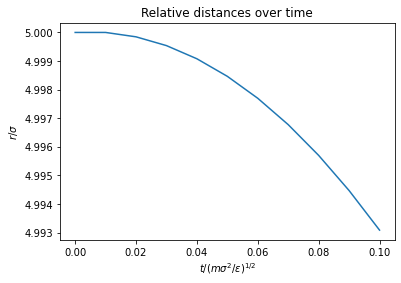

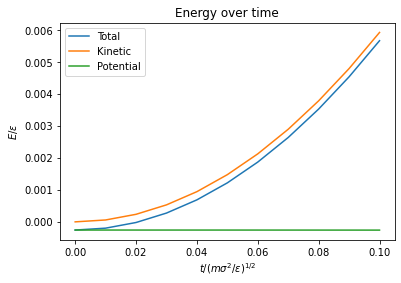

In [9]:
#Create a 2x8 matrix to store the velocity of each particle at each step in time.
next_step_velocity = np.copy(init_vel)

#Create a 2x8 matrix to store the position of each particle at each step in time.
next_step_position = np.copy(init_pos)

final_vector_kin = np.array([kin_en(init_vel)])
final_vector_pot = np.array([pot_en(final_matrix_pos, n)])
final_vector_energy = np.array([kin_en(init_vel) + pot_en(final_matrix_pos, n)])

final_rel_dist = atomic_distances(init_pos, 0)

for i in range(number_of_steps):
    next_step_position, next_step_velocity = euler(final_matrix_pos, final_matrix_vel)
    for k in range(n): #implement boundary conditions
        for j in range(n):
            next_step_position[k, j] = next_step_position[k, j]% L
    final_matrix_pos =  np.concatenate((final_matrix_pos, next_step_position), axis=1, out=None)
    final_matrix_vel =  np.concatenate((final_matrix_vel, next_step_velocity), axis=1, out=None)
    final_vector_kin = np.concatenate((final_vector_kin, np.array([kin_en(next_step_velocity)])), axis = 0, out = None)
    final_vector_pot = np.concatenate((final_vector_pot, np.array([pot_en(final_matrix_pos, n)])), axis=0, out=None)
    final_vector_energy = np.concatenate((final_vector_energy, np.array([kin_en(next_step_velocity) + pot_en(final_matrix_pos, n)])), axis=0, out=None)
    final_rel_dist = np.concatenate((final_rel_dist, atomic_distances(next_step_position, 0)), axis = 1, out = None)

#print("Positions:\n" , final_matrix_pos)
print("Velocities:\n" , final_matrix_vel)
#print("Energy:\n" , final_vector_pot)
#print(final_vector_kin)
#print(final_vector_pot)
#print(final_rel_dist)



plt.plot(times,final_rel_dist[0, 1::2, ])
plt.title("Relative distances over time")
plt.xlabel("$t/(m\sigma^2/\epsilon)^{1/2}$")
plt.ylabel("$r/\sigma$")
plt.show()

plt.plot(times, final_vector_energy, label = "Total")
plt.plot(times, final_vector_kin, label = "Kinetic")
plt.plot(times, final_vector_pot, label = "Potential")
plt.legend()
plt.title("Energy over time")
plt.xlabel("$t/(m\sigma^2/\epsilon)^{1/2}$")
plt.ylabel("$E/\epsilon$")
plt.show()